## Liquid helium Notebook
------
To run on NERSC:

module load python

source activate lims-test


In [1]:
#import sys
#sys.path.append('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/')
#import feldman_cousins as fc

import numpy as np
import matplotlib.pyplot as plt

import darklim

from multihist import Hist1d

%matplotlib inline

In [13]:
darklim.feldman_cousins.FC_ints(162,0.49813)

(141.03566502806444, 183.5400078576643)

In [5]:
#fc.FC_ints(180,2.0)

(156.53651734780593, 201.04636900125587)

1-fold coincidence:
integral from 1e-06 to 1.0 keV = 4.15e+04 evts/day
= 4.80e-01 evts/s
 
2-fold coincidence:
integral from 1e-06 to 1.0 keV = 1.49e+00 evts/day
= 1.73e-05 evts/s
 
3-fold coincidence:
integral from 1e-06 to 1.0 keV = 3.58e-05 evts/day
= 4.15e-10 evts/s
 
4-fold coincidence:
integral from 1e-06 to 1.0 keV = 4.30e-10 evts/day
= 4.98e-15 evts/s
 


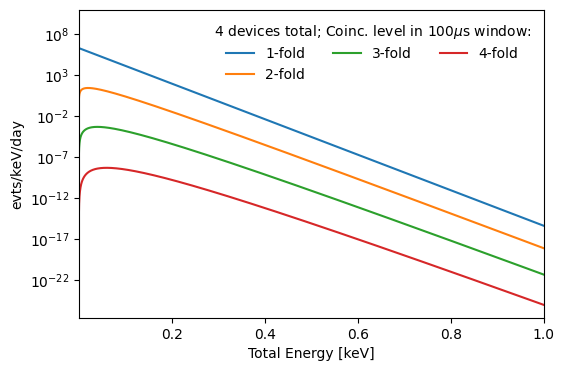

In [2]:
# test the nfold LEE function

fig, ax = plt.subplots(1,figsize=(6,4))

save = False

#bins = np.linspace(0.0001,1,1000)
bins = np.geomspace(1e-6,1,1000)

n_devices = 4
coinc = np.arange(1,5)
window = 100e-6# s
for n in coinc:
    
    print('{}-fold coincidence:'.format(n))
    model = darklim.sensitivity.n_fold_lee(bins,m=n_devices,n=n,w=window)
    
    integral = np.trapz(model,x=bins)
    print('integral from {} to {} keV = {:.2e} evts/day'.format(bins[0],bins[-1],integral))
    print('= {:0.2e} evts/s'.format(integral/24/3600))
    print(' ')
    
    plt.plot(bins,model,label='{:d}-fold'.format(n))
    
    if save:
        outname = 'LEE_bkg_{:d}device_{:d}fold_{:0.0f}mus.txt'.format(n_devices,n,window/1e-6)
        tot = np.column_stack( (bins, model) )
        np.savetxt(outname,tot,fmt=['%.5e','%0.5e'] ,delimiter=' ', header='energy[keV] evts/day/keV')
    
#lhe_mass = 0.010 # kg
#ax.axhline(1*lhe_mass,label='1 DRU in 10g LHe'.format(n),color='black',ls='--') # 1 DRU=1 evt/keV/d/kg
#plt.plot(bins,
    
ax.set_ylabel('evts/keV/day')
ax.set_xlabel('Total Energy [keV]')
ax.set_xlim(1e-6,1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(None,1e11)
ax.legend(loc='upper right',frameon=False,title='{:d} devices total;'.format(n_devices)+' Coinc. level in {:0.0f}'.format(window*1e6)+r'$\mu$s window:',ncol=3)

In [10]:
# Detector info setup

n_devices = 4
coinc = 2
window = 100e-6 # s

mass_det = 0.010 # mass in kg
time_elapsed = 1000 # days
efficiency = 1.0

tm = 'He' # target name

energy_res = 0.373e-3 # energy resolution in keV
threshold = coinc*5*energy_res

print('detector mass is {} kg = {} g'.format(mass_det,mass_det*1000))
print('run time is {} days'.format(time_elapsed))
print('exposure is {} kg-days'.format(mass_det*time_elapsed))
print('threshold = {:0.3f} eV'.format(threshold*1000))
print('assuming {:d}-fold coincidence amongst {:d} devices in a {:0.1f} microsecond window'.format(coinc,n_devices,window/1e-6))



detector mass is 0.01 kg = 10.0 g
run time is 1000 days
exposure is 10.0 kg-days
threshold = 3.730 eV
assuming 2-fold coincidence amongst 4 devices in a 100.0 microsecond window


In [5]:
def smeared_wimp(en_interp,mass,sigma0=1e-41,tm='He',res=None):
    init_rate = darklim.limit.drde(en_interp, mass, sigma0, tm=tm)
    if res is not None:
        init_rate = darklim.limit.gauss_smear(en_interp, init_rate, res)
    return init_rate

expect 1493.1 evts
created 1508.0 evts


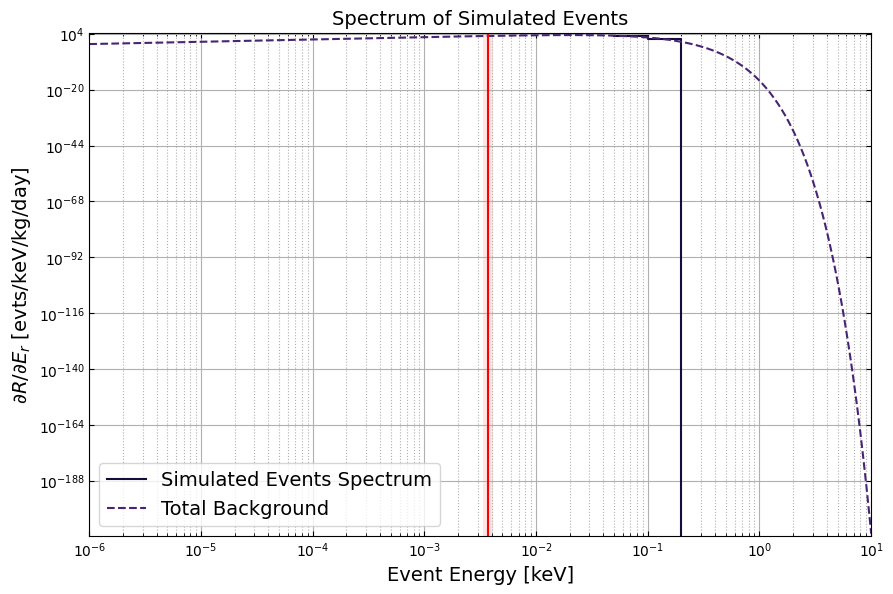

In [11]:
SE = darklim.sensitivity.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)

SE.reset_sim()
#SE.add_flat_bkgd(1) # flat background of 1 DRU
#SE.add_nfold_lee_bkgd(m=4,n=2,w=window)
SE.add_nfold_lee_bkgd(m=n_devices,n=coinc,w=window)

dmmass = 0.02
xsec = 2e-38

#SE.add_dm_bkgd(dmmass, xsec)

#en_interp = np.geomspace(1e-6,1, num=1000)
#dm = smeared_wimp(en_interp,dmmass,sigma0=xsec,tm=tm,res=energy_res)

emax = 10

gen_evts = SE.generate_background(emax, e_low=1e-6, npts=1000, plot_bkgd=True, verbose=True)
ax = plt.gca()

#ax.plot(en_interp,dm,ls='-',alpha=1,color='magenta',label='Smeared WIMP')

#plt.ylim(0.1,50)
ax.set_xscale('log')
ax.set_xlim(1e-6,emax)
ax.axvline(threshold,ls='-',color='red')
ax.axvspan(threshold-energy_res,threshold+energy_res,facecolor='red',alpha=0.1)

#ax.legend(labels=['Simulated Evts','1 DRU','n-fold LEE','Unsmeared WIMP','Total Bkg','Smeared WIMP'])



Text(0.5, 0, 'Energy [keV]')

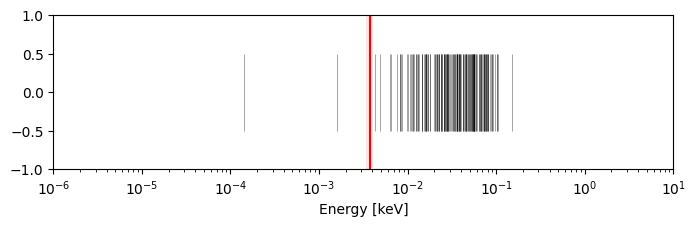

In [9]:
fig, ax = plt.subplots(figsize=(8,2))
ax.vlines(gen_evts,-0.5,0.5,color='black',lw=0.5, alpha=0.5)
ax.axvline(threshold,ls='-',color='red')
ax.axvspan(threshold-energy_res,threshold+energy_res,facecolor='red',alpha=0.1)

ax.set_yscale('linear')
ax.set_ylim(-1,1)

ax.set_xscale('log')
ax.set_xlim(1e-6,emax)
ax.set_xlabel('Energy [keV]')

## Reset and run the sens projection

In [5]:
SE = darklim.sensitivity.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)
SE.reset_sim()

SE.add_flat_bkgd(1) # flat background of 1 DRU
SE.add_nfold_lee_bkgd(m=n_devices,n=coinc,w=window)


In [6]:
# run the simulation with FC limits

#m_dms=np.geomspace(0.1, 2, num=10)

m_dm, sig, ul = SE.run_sim_fc(
    0,
    threshold,
    10,
    e_low=1e-6,
    #m_dms=np.array([1]),
    m_dms=np.geomspace(0.01, 2, num=5),
    nexp=20, # increase for a better estimate, 1 is generally used for diagnostics
    npts=1000,
    plot_bkgd=False,
    res=energy_res,
    verbose=False,
    sigma0=1e-36
    #sigma0=1e-41
)

print('\nexposure was ',SE.exposure,' kg-days')
print('masses = ',m_dm)
print('ULs (evts) = ',ul)
print('ULs (xsec) = ',sig)

Treating 1.00 DRU Bkg as a known bkg
Running toy number 0...
Running toy number 10...

exposure was  1.0  kg-days
masses =  [0.01       0.03760603 0.14142136 0.53182959 2.        ]
ULs (evts) =  169.52606422282645
ULs (xsec) =  [           inf 6.76497103e-38 1.16313922e-38 2.35784172e-38
 3.93497362e-38]


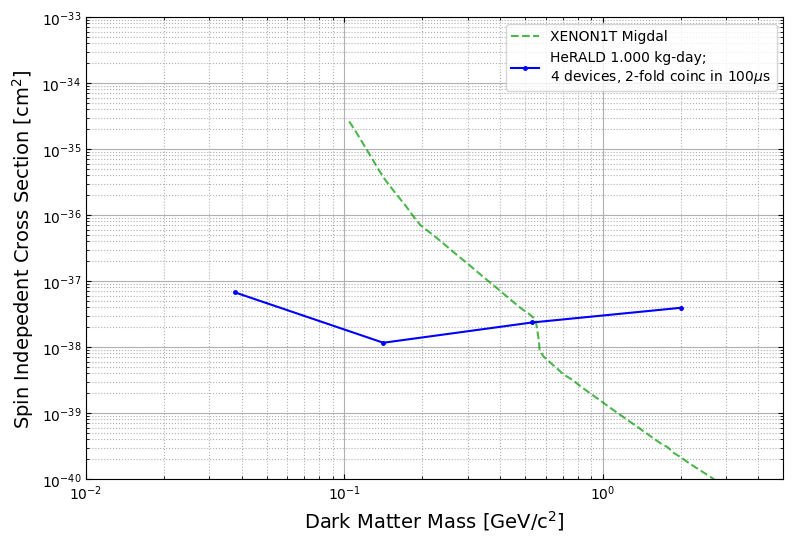

In [7]:
#fig, ax = plt.subplots(figsize=(6, 4))
#plt.plot(m_dm, ul, color='b',marker='.',ms=5,label=lab)

#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.set_ylim(100,200)
#ax.set_xlim(0.01, 5)
#ax.set_xlabel("Dark Matter Mass [GeV/c$^2$]", fontsize=14)
#ax.set_ylabel("Median Upper Limit [events]", fontsize=14)
#ax.set_title("Estimated Sensitivity", fontsize=14)
#ax.grid()


fig, ax = plt.subplots(figsize=(9, 6))

x1tmig = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/XENON1T-Migdal.txt')
#cresst = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/CRESST.txt')

plt.plot(*(x1tmig.T),color=(0.,0.6,0.,0.7),ls='--',label='XENON1T Migdal')
#plt.plot(*(cresst.T),color=(0.8,0.1,0.1,0.7),label='CRESST')

lab = 'HeRALD {:0.3f} kg-day;\n{:d} devices, {:d}-fold coinc in {:0.0f}$\mu$s'.format(SE.exposure,n_devices,coinc,window/1e-6)
plt.plot(m_dm, sig, color='b',marker='.',ms=5,label=lab)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-40, 1e-33)
ax.set_xlim(0.01, 5)
ax.set_xlabel("Dark Matter Mass [GeV/c$^2$]", fontsize=14)
ax.set_ylabel("Spin Indepedent Cross Section [cm$^2$]", fontsize=14)
#ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

ax.legend(loc='upper right',frameon=True)

On mass 1 of 15.
On mass 2 of 15.
On mass 3 of 15.
On mass 4 of 15.
2.303766965866089
2.303766965866089
On mass 5 of 15.
2.806710958480835
2.806710958480835
On mass 6 of 15.
6.438226699829102
6.438226699829102
On mass 7 of 15.
15.754807472229004
15.754807472229004
On mass 8 of 15.
 Routine CnMax failed.
38.2678108215332
38.2678108215332
On mass 9 of 15.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
75.77655792236328
75.77655792236328
On mass 10 of 15.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
150.7525177001953
150.7525177001953
On mass 11 of 15.
 Routin

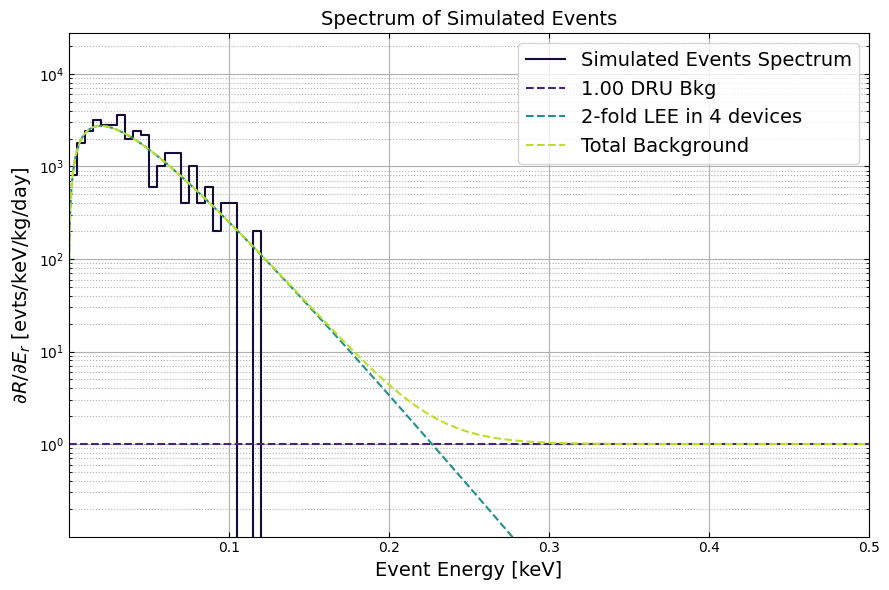

In [14]:
# run the simulation 

#m_dms=np.geomspace(0.1, 2, num=10)

m_dm, sig = SE.run_sim(
    threshold,
    0.5,
    e_low=1e-6,
    #m_dms=np.array([0.5]),
    m_dms=np.geomspace(0.01, 2, num=15),
    nexp=10, # increase for a better estimate, 1 is generally used for diagnostics
    npts=1000,
    plot_bkgd=True,
    res=energy_res,
    verbose=True,
    sigma0=1e-36
    #sigma0=1e-41
)

print('\nexposure was ',SE.exposure,' kg-days')
print('masses = ',m_dm)
print('ULs = ',sig)

Plot results

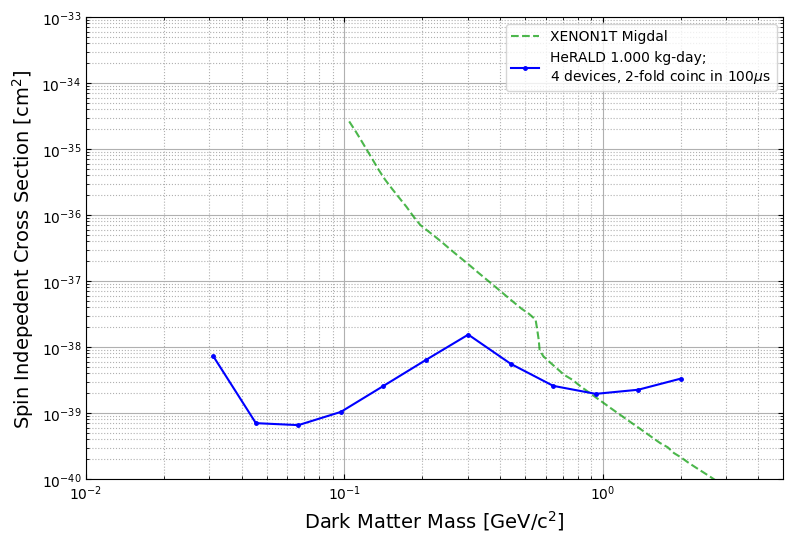

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))

x1tmig = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/XENON1T-Migdal.txt')
#cresst = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/CRESST.txt')

plt.plot(*(x1tmig.T),color=(0.,0.6,0.,0.7),ls='--',label='XENON1T Migdal')
#plt.plot(*(cresst.T),color=(0.8,0.1,0.1,0.7),label='CRESST')

lab = 'HeRALD {:0.3f} kg-day;\n{:d} devices, {:d}-fold coinc in {:0.0f}$\mu$s'.format(SE.exposure,n_devices,coinc,window/1e-6)
plt.plot(m_dm, sig, color='b',marker='.',ms=5,label=lab)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-40, 1e-33)
ax.set_xlim(0.01, 5)
ax.set_xlabel("Dark Matter Mass [GeV/c$^2$]", fontsize=14)
ax.set_ylabel("Spin Indepedent Cross Section [cm$^2$]", fontsize=14)
#ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

ax.legend(loc='upper right',frameon=True)

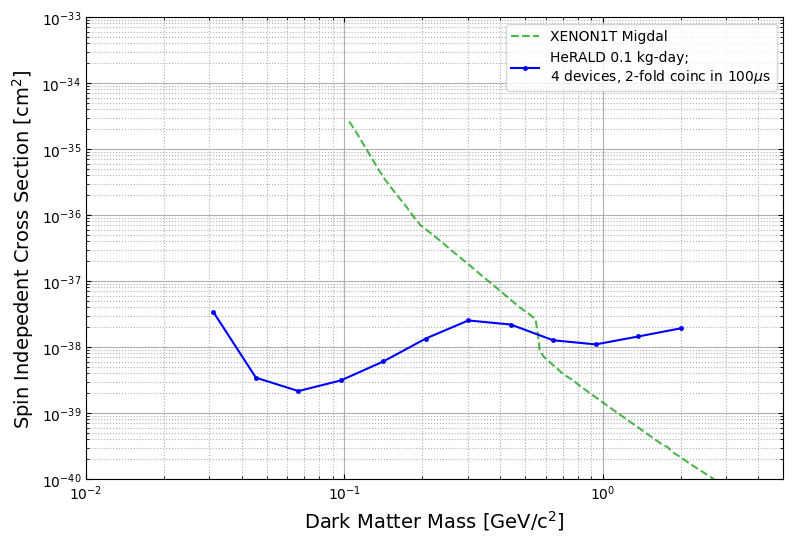

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))

x1tmig = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/XENON1T-Migdal.txt')
#cresst = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/CRESST.txt')

plt.plot(*(x1tmig.T),color=(0.,0.6,0.,0.7),ls='--',label='XENON1T Migdal')
#plt.plot(*(cresst.T),color=(0.8,0.1,0.1,0.7),label='CRESST')

lab = 'HeRALD {:0.1f} kg-day;\n{:d} devices, {:d}-fold coinc in {:0.0f}$\mu$s'.format(SE.exposure,n_devices,coinc,window/1e-6)
plt.plot(m_dm, sig, color='b',marker='.',ms=5,label=lab)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-40, 1e-33)
ax.set_xlim(0.01, 5)
ax.set_xlabel("Dark Matter Mass [GeV/c$^2$]", fontsize=14)
ax.set_ylabel("Spin Indepedent Cross Section [cm$^2$]", fontsize=14)
#ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

ax.legend(loc='upper right',frameon=True)

In [16]:
# save results to txt file
outname = 'HeRALD_{:0.1f}kgday_{:d}device_{:d}fold_{:0.0f}mus.txt'.format(SE.exposure,n_devices,coinc,window/1e-6)

if False:
    tot = np.column_stack( (m_dm, sig) )
    np.savetxt(outname,tot,fmt=['%.5e','%0.5e'] ,delimiter=' ')

